In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_STATE = 42

from CollaborativeFiltering import CollaborativeFiltering

In [2]:
path = 'ml-latest-small'

# filenames = ['ratings']
# for fn in filenames:
#     vars()[fn] = pd.read_csv(path + '/' + fn + '.csv')

ratings = pd.read_csv(path + '/ratings.csv', usecols=['userId', 'movieId', 'rating'], index_col=['userId', 'movieId'])
ratings.fillna(value=0, inplace=True)
ratings.head()

rating
userId movieId        
1      31          2.5
       1029        3.0
       1061        3.0
       1129        2.0
       1172        4.0

In [17]:
def split_train_test(X, frac, random_state=RANDOM_STATE):
    """split train and test sets and unstack into two-dimension dataframes"""
    testset = X.sample(frac=frac, random_state=random_state)
    trainset = X.copy()
    trainset.loc[testset.index] = np.nan
    trainset.dropna(inplace=True)
    
    return trainset, testset

def unstack_data(Xsub_val, Xfull):
    idx_val = Xsub_val.index
    Xsub = pd.DataFrame().reindex_like(Xfull)
    Xsub.loc[idx_val] = Xsub_val
    
    Xsub = Xsub.unstack()
    Xsub.fillna(0, inplace=True)
    
    return Xsub

def mse(cf, obs):
    preds = pd.DataFrame(cf.full_matrix(), index=obs.index, columns=obs.columns)
    
    n = np.count_nonzero(obs.values)
    sq_err = pow((preds - obs) * (obs > 0), 2)
    mse = sq_err.sum().sum() / n
    
    return mse

from sklearn.model_selection import KFold

def cf_param(param_name, param, K, iterations):
    if param_name == 'K':
        cf = CollaborativeFiltering(K=param, iterations=iterations)
    elif param_name == 'alpha':
        cf = CollaborativeFiltering(alpha=param, K=K, iterations=iterations)
    elif param_name == 'beta':
        cf = CollaborativeFiltering(beta=param, K=K, iterations=iterations)
    elif param_name == 'iterations':
        cf = CollaborativeFiltering(K=K, iterations=param)
    else:
        return 'invalid param_name'
        
    return cf

def validation_curve(X, param_name, param_range, cv=3, K=10, iterations=10,
                     shuffle=True, random_state=None,
                     graph=False, xlog=False):
    kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    kf.get_n_splits(X)
    
    train_mse = np.zeros((len(param_range), cv))
    test_mse = np.zeros((len(param_range), cv))
    
    for i, param in enumerate(param_range):
        j = 0
        for train_idx, test_idx in kf.split(X):
            cf = cf_param('K', 5, K=10, iterations=5)

            testset1 = X.iloc[test_idx]
            trainset1 = X.copy()
            trainset1.iloc[test_idx] = np.nan

            testset1 = unstack_data(testset1, X)
            trainset1 = unstack_data(trainset1, X)

            train_process = cf.train(trainset1.values)

            train_mse[i][j] = mse(cf, trainset1)
            test_mse[i][j] = mse(cf, testset1)
                        
            j += 1
    
    if graph:
        train_mse_mean, train_mse_std = np.mean(train_mse, axis=1), np.std(train_mse, axis=1)
        test_mse_mean, test_mse_std = np.mean(test_mse, axis=1), np.std(test_mse, axis=1)
        
        plt.plot(param_range, train_mse_mean, 'o-', label='Training MSE')
        plt.fill_between(param_range, train_mse_mean - train_mse_std, train_mse_mean + train_mse_std, alpha=0.1)
        
        plt.plot(param_range, test_mse_mean, 'o-', label='Test MSE')
        plt.fill_between(param_range, test_mse_mean - test_mse_std, test_mse_mean + test_mse_std, alpha=0.1)
        
        plt.legend()
        plt.grid()
        
        plt.ylabel('MSE')
        plt.xlabel(param_name)
        
        if xlog: plt.semilogx()
        
        plt.title('Validation curve of Collaborative Filtering in respect to {}'.format(param_name))
    
    return param_range, train_mse, test_mse

def learning_curve(X, Xtrain, Xtest, steps, K, iterations, alpha, beta, random_state, graph=True):
    mse_train = np.zeros(len(steps))
    mse_test = np.zeros(len(steps))

    for i, step in enumerate(steps):
        Xsub = unstack_data(Xtrain.sample(frac=step, random_state=random_state), X)
        cf = CollaborativeFiltering(K=K, iterations=iterations, verbose=False)  
        cf.train(Xsub.values)

        mse_train[i] = mse(cf, Xsub)
        mse_test[i] = mse(cf, Xtest)
            
    if graph:
        plt.title('Learning curve')
        plt.plot(steps, mse_test, 'o-', label='Training')
        plt.plot(steps, mse_train, 'o-', label='Test')
        plt.grid()
        plt.legend()
        plt.xlabel('Training samples')
        plt.ylabel('MSE')
        
    return mse_train, mse_test

In [4]:
trainset, testset = split_train_test(ratings, 0.3, RANDOM_STATE)
testset = unstack_data(testset, ratings)

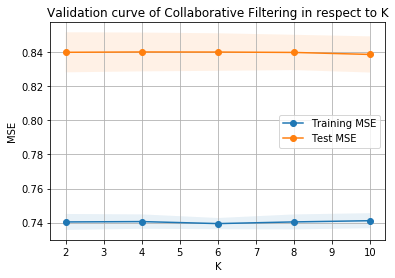

In [5]:
param_range, train_mse, test_mse = validation_curve(trainset,
                                                    param_name='K',
                                                    param_range=np.linspace(2, 10, 5, endpoint=True, dtype=int),
                                                    cv=3,
                                                    iterations=10,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE,
                                                    graph=True)

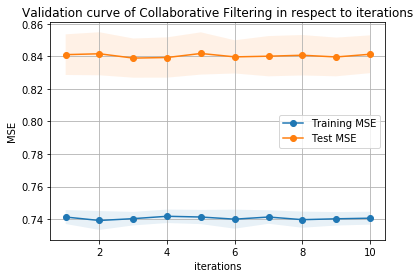

In [6]:
param_range, train_mse, test_mse = validation_curve(trainset,
                                                    param_name='iterations',
                                                    param_range=np.linspace(1, 10, 10, endpoint=True, dtype=int),
                                                    cv=3,
                                                    iterations=10,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE,
                                                    graph=True)

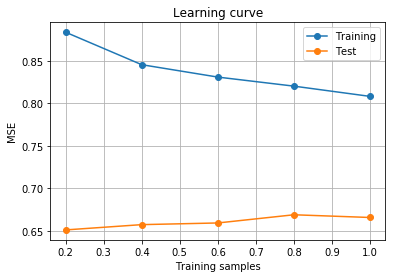

In [19]:
mse_train, mse_test = learning_curve(ratings, trainset, testset,
                                     K=5, iterations=10, alpha=0.01, beta=0.001,
                                       steps=np.linspace(0.2, 1.0, num=5),
                                       random_state=RANDOM_STATE, graph=True)